In [1]:
import pandas as pd
import mlflow
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns  # For enhanced data visualization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from commons.data_loading import (load_raw_data,
                                  transformed_employee_performance,
                                  feature_engineered_employee_performance)
from commons.commons import get_features

c:\Users\Harold David\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_scaler(scaler, name="standard_scaler", filename='scaler'):
    """Save and log the StandardScaler to MLflow."""
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Hyperparameter Tuning")

    with mlflow.start_run(run_name=name):
        joblib.dump(scaler, f"{filename}.pkl")
        mlflow.log_artifact(f"{filename}.pkl")
        mlflow.sklearn.log_model(scaler, name)



In [3]:
def get_data():
    data_df = load_raw_data()[:2000]
    data_df = transformed_employee_performance(data_df=data_df)
    new_df, X_scaler, y_scaler = feature_engineered_employee_performance(
        data_df=data_df, return_scaler=True
    )
    save_scaler(X_scaler, 'x_standard_scaler', 'x_scaler')
    save_scaler(y_scaler, 'y_standard_scaler', 'y_scaler')
    return new_df, X_scaler, y_scaler

new_df, X_scaler, y_scaler = get_data()



Found


2025/02/24 12:39:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/02/24 12:39:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run x_standard_scaler at: http://localhost:5000/#/experiments/3/runs/8a5af1544901442291a2160c7de2b8ad
🧪 View experiment at: http://localhost:5000/#/experiments/3


2025/02/24 12:39:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/02/24 12:39:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run y_standard_scaler at: http://localhost:5000/#/experiments/3/runs/09d25dc2668444f1af946888089f37f3
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [4]:
# Define the Optuna objective function for regression
def objective(trial, X_train, X_test, y_train, y_test, parent_run_id):
    # Suggest a model to use from the given list
    model_name = trial.suggest_categorical("model", ["linear_regression", "rf_regressor", "gboost_regressor"])
    mlflow.start_run(run_name=model_name, nested=True)  # Start a child run in MLflow

    # Define the model based on the selected model type
    if model_name == "linear_regression":
        model = LinearRegression()  # Simple linear regression
    elif model_name == "rf_regressor":
        # Suggest hyperparameters for RandomForestRegressor
        n_estimators = trial.suggest_int("n_estimators", 50, 200)
        max_depth = trial.suggest_int("max_depth", 10, 30)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        mlflow.log_param("n_estimators", n_estimators)  # Log parameters to MLflow
        mlflow.log_param("max_depth", max_depth)
    else:
        # Suggest hyperparameters for GradientBoostingRegressor
        n_estimators = trial.suggest_int("n_estimators", 50, 200)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("learning_rate", learning_rate)

    # Train the model and evaluate its performance
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
    r2 = r2_score(y_test, y_pred)  # Calculate R² score
    mlflow.log_metric("mse", mse)  # Log MSE to MLflow
    mlflow.log_metric("r2", r2)  # Log R² score to MLflow
    mlflow.end_run()  # End the MLflow run
    trial.set_user_attr("model", model)  # Save the model in Optuna trial attributes
    trial.set_user_attr("r2", r2)  # Save the R² score in Optuna trial attributes
    return mse  # Return MSE for Optuna to minimize

[I 2025-02-24 12:39:24,607] A new study created in memory with name: no-name-ef7ced2b-6d17-4992-a064-2410bdede80f
[I 2025-02-24 12:39:24,750] Trial 0 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/0fdeff70ad294992943670248cdf1a76
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:25,720] Trial 1 finished with value: 1.0194884420543064 and parameters: {'model': 'gboost_regressor', 'n_estimators': 192, 'learning_rate': 0.046562756474593646}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/1ae1b2274f4c40bcbda2c168c2baeca7
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:27,871] Trial 2 finished with value: 1.04276561661373 and parameters: {'model': 'rf_regressor', 'n_estimators': 128, 'max_depth': 23}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/2b5f1ecf93c94a3d96d22d6f72af0d30
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:28,986] Trial 3 finished with value: 1.045090682118605 and parameters: {'model': 'rf_regressor', 'n_estimators': 63, 'max_depth': 20}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/4437bec3520d4921a30c305ed557378b
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:30,188] Trial 4 finished with value: 1.0490469030041654 and parameters: {'model': 'rf_regressor', 'n_estimators': 69, 'max_depth': 22}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:30,280] Trial 5 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/9656b50e8a86402f8efd88fb4f539fa9
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/3ea44caf7baa460eb5badeec3e9b4ba2
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:30,438] Trial 6 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:30,558] Trial 7 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/93359cf6ae634125af24c430f1e36ed7
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/fcc0fe220175483bb62ce90ad8e31699
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:32,116] Trial 8 finished with value: 1.0421770204557743 and parameters: {'model': 'rf_regressor', 'n_estimators': 104, 'max_depth': 14}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/c50d2c1641094a9caef22875fb4d95c0
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:34,838] Trial 9 finished with value: 1.0356429715969835 and parameters: {'model': 'rf_regressor', 'n_estimators': 156, 'max_depth': 24}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/706b60ff38c5455288349455a7cb50de
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:35,763] Trial 10 finished with value: 1.110454763101256 and parameters: {'model': 'gboost_regressor', 'n_estimators': 193, 'learning_rate': 0.19436319769897603}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:35,920] Trial 11 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/5d61b6e9f5ff4805b21e3ccc15c0428a
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/b7199df89d9644bd8bdde2b5fd6a42d8
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:36,092] Trial 12 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:36,219] Trial 13 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/f12f42b4fb604c28bd6636fa5db4adcc
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/001d9a65c67c4c0a98a2b1714fee0758
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:36,376] Trial 14 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:36,521] Trial 15 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/64207dca91894314ba8d299a98ef881e
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/6931270766e24421967e81c7d9db3550
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:37,116] Trial 16 finished with value: 1.0671066854711757 and parameters: {'model': 'gboost_regressor', 'n_estimators': 109, 'learning_rate': 0.15079669453636663}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:37,270] Trial 17 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/946163317c9142d198427f0bc008f1b9
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/7a2715b0b7b045b5a5f6dbec97d2a391
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:37,378] Trial 18 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.
[I 2025-02-24 12:39:37,538] Trial 19 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0189953603724404.


🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/0ee07c6f03844e96944d43bcf5153968
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/c4cc60c19e1e49d2b5162aef1e6d3b54
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:38,342] Trial 20 finished with value: 1.005199627596037 and parameters: {'model': 'gboost_regressor', 'n_estimators': 156, 'learning_rate': 0.013995271517859995}. Best is trial 20 with value: 1.005199627596037.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/e52bea4cfe5c45deaeffb6a862bab350
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:39,120] Trial 21 finished with value: 1.0037009652549114 and parameters: {'model': 'gboost_regressor', 'n_estimators': 148, 'learning_rate': 0.013203723348092666}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/7fd25c15093f415aaf424337bbded0b4
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:39,905] Trial 22 finished with value: 1.0050843409327144 and parameters: {'model': 'gboost_regressor', 'n_estimators': 152, 'learning_rate': 0.01219450549343315}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/077c0dfe1a27470ea1708bc202e28c47
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:40,647] Trial 23 finished with value: 1.0049334213449352 and parameters: {'model': 'gboost_regressor', 'n_estimators': 157, 'learning_rate': 0.011508224283542687}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/398579a9fb234aad9b826cff61b360cf
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:41,449] Trial 24 finished with value: 1.0069139150484616 and parameters: {'model': 'gboost_regressor', 'n_estimators': 155, 'learning_rate': 0.01515300516136695}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/c42cc35f681b4648b03d55b48733e237
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:42,196] Trial 25 finished with value: 1.0333240106706845 and parameters: {'model': 'gboost_regressor', 'n_estimators': 141, 'learning_rate': 0.06438065867324028}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/f8de0b43aea5407fb7c923938d07dad6
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:43,037] Trial 26 finished with value: 1.0118212365958705 and parameters: {'model': 'gboost_regressor', 'n_estimators': 173, 'learning_rate': 0.019104615945657474}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/f527acba84a2494281e3b23f5504779d
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:43,988] Trial 27 finished with value: 1.021671741604046 and parameters: {'model': 'gboost_regressor', 'n_estimators': 170, 'learning_rate': 0.07066045845555288}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/a37b1e51211b42778021cf0fabed8482
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:44,682] Trial 28 finished with value: 1.0183632263813234 and parameters: {'model': 'gboost_regressor', 'n_estimators': 128, 'learning_rate': 0.039312514148035944}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/f0aacd768fa048979ec5e451eb3250d8
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:45,543] Trial 29 finished with value: 1.0554031697966366 and parameters: {'model': 'gboost_regressor', 'n_estimators': 172, 'learning_rate': 0.10413268715474783}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/f133a4d1052e49faba84a6717920f509
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:46,266] Trial 30 finished with value: 1.0161463375172455 and parameters: {'model': 'gboost_regressor', 'n_estimators': 143, 'learning_rate': 0.045684170440778}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/cd99e544a6584ce1a6145c69871c5393
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:47,036] Trial 31 finished with value: 1.004471560513014 and parameters: {'model': 'gboost_regressor', 'n_estimators': 152, 'learning_rate': 0.011667617077590692}. Best is trial 21 with value: 1.0037009652549114.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/be418263f0f249459da30e18cfa4a7a7
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:47,967] Trial 32 finished with value: 1.0035040762686862 and parameters: {'model': 'gboost_regressor', 'n_estimators': 145, 'learning_rate': 0.01050562563588571}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/4558d7706f4c4a7998264ecff57537ab
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:48,598] Trial 33 finished with value: 1.0158207949851892 and parameters: {'model': 'gboost_regressor', 'n_estimators': 113, 'learning_rate': 0.036554715773964616}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/c522f87707064da3842b6efffa9dbe36
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:49,371] Trial 34 finished with value: 1.004620360221007 and parameters: {'model': 'gboost_regressor', 'n_estimators': 141, 'learning_rate': 0.012436902007923696}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/30577127926e4456b940df10a861c783
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:50,065] Trial 35 finished with value: 1.013061575524547 and parameters: {'model': 'gboost_regressor', 'n_estimators': 133, 'learning_rate': 0.032777923237068615}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/8e25b41707444b1c99516d1e0b5c62bc
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:50,631] Trial 36 finished with value: 1.0130376847358642 and parameters: {'model': 'gboost_regressor', 'n_estimators': 93, 'learning_rate': 0.06642236696934904}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/0466ded973a0409abf65d525843ef81c
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:51,387] Trial 37 finished with value: 1.0415503800305759 and parameters: {'model': 'gboost_regressor', 'n_estimators': 143, 'learning_rate': 0.08940362259817754}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/215e46338e844e6e95005aa364925a04
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:52,043] Trial 38 finished with value: 1.0190869365039072 and parameters: {'model': 'gboost_regressor', 'n_estimators': 121, 'learning_rate': 0.03493321377430114}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/3a6b8433c433422c987944969414710f
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:54,782] Trial 39 finished with value: 1.0420033426084958 and parameters: {'model': 'rf_regressor', 'n_estimators': 168, 'max_depth': 30}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/bb4f2de81bb042b398498d340d042ae3
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:55,478] Trial 40 finished with value: 1.0736933453249753 and parameters: {'model': 'gboost_regressor', 'n_estimators': 138, 'learning_rate': 0.1337088653871455}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/43ed6ad79359493595abc0467018a96d
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:56,294] Trial 41 finished with value: 1.0063932998851015 and parameters: {'model': 'gboost_regressor', 'n_estimators': 161, 'learning_rate': 0.014001737545184148}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/1ea421e08dae48dc9c282bdf2f240bd2
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:57,189] Trial 42 finished with value: 1.017984214871796 and parameters: {'model': 'gboost_regressor', 'n_estimators': 184, 'learning_rate': 0.02687184683732561}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/8c94aa1e7d2b4341bd641c4dfda8677c
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:39:57,958] Trial 43 finished with value: 1.012700381202109 and parameters: {'model': 'gboost_regressor', 'n_estimators': 146, 'learning_rate': 0.025444206078605765}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/264b2b22a6474890b0f55fce6629b8c7
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:40:00,092] Trial 44 finished with value: 1.0300402161676516 and parameters: {'model': 'rf_regressor', 'n_estimators': 182, 'max_depth': 10}. Best is trial 32 with value: 1.0035040762686862.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/d27774fe409c4800bd2d8515ec6727c8
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:40:00,747] Trial 45 finished with value: 1.0031356480978457 and parameters: {'model': 'gboost_regressor', 'n_estimators': 122, 'learning_rate': 0.011463650701573952}. Best is trial 45 with value: 1.0031356480978457.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/79416c5cf4244f17a3dae6be18ea384e
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:40:01,438] Trial 46 finished with value: 1.0213022889292445 and parameters: {'model': 'gboost_regressor', 'n_estimators': 126, 'learning_rate': 0.05243078143252539}. Best is trial 45 with value: 1.0031356480978457.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/ffbbd41bd3d64fbe9fa79d242ce2b7b3
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:40:02,080] Trial 47 finished with value: 1.0108950778472758 and parameters: {'model': 'gboost_regressor', 'n_estimators': 119, 'learning_rate': 0.028384546390080465}. Best is trial 45 with value: 1.0031356480978457.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/76a9850f70ac428c9c2c9e11aa798823
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:40:03,759] Trial 48 finished with value: 1.0421028488678985 and parameters: {'model': 'rf_regressor', 'n_estimators': 97, 'max_depth': 29}. Best is trial 45 with value: 1.0031356480978457.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/09d8a589cbe74ff995bfabacb642eedb
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 12:40:04,432] Trial 49 finished with value: 1.011382883393578 and parameters: {'model': 'gboost_regressor', 'n_estimators': 134, 'learning_rate': 0.026544373344591005}. Best is trial 45 with value: 1.0031356480978457.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/8b0aaf7d11384cafa2c7cf8238d368f7
🧪 View experiment at: http://localhost:5000/#/experiments/3


C:\Users\Harold David\AppData\Local\Temp\ipykernel_33812\407424292.py:20: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\Harold David\AppData\Local\Temp\ipykernel_33812\407424292.py:24: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = optuna.visualization.matplotlib.plot_param_importances(study)


🏃 View run optuna_hpo at: http://localhost:5000/#/experiments/3/runs/d62a2cfa3ee949f4a35ff9347f4e79c6
🧪 View experiment at: http://localhost:5000/#/experiments/3


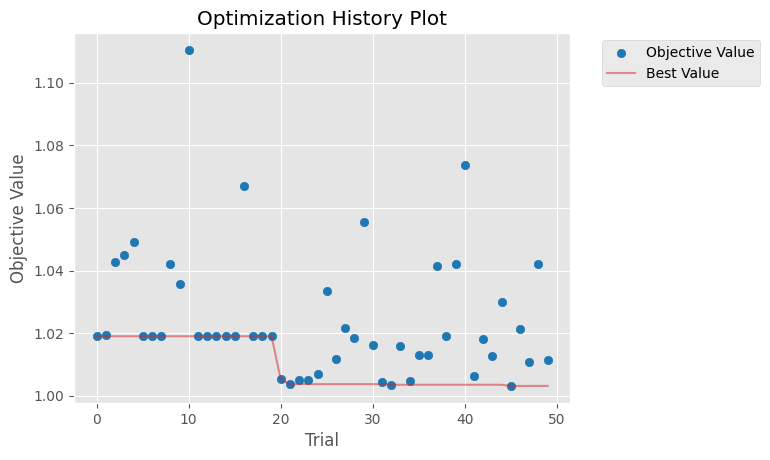

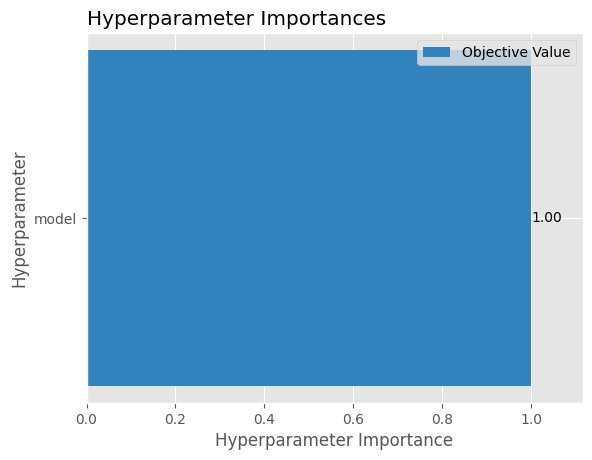

In [5]:
# Function to run hyperparameter optimization and visualize results
def hyperparameter_optimization(new_df):
    mlflow.set_experiment("Hyperparameter Tuning")  # Set MLflow experiment
    X = new_df.drop(columns=["Employee_Satisfaction_Score"])  # Features
    y = new_df["Employee_Satisfaction_Score"]  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data

    # Start a parent run for Optuna trials
    with mlflow.start_run(run_name="optuna_hpo") as parent_run:
        study = optuna.create_study(direction="minimize")  # Optuna study to minimize MSE
        study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test, parent_run.info.run_id), n_trials=50)
        mlflow.log_param("best_params", study.best_params)  # Log best parameters to MLflow
        mlflow.log_metric("best_mse", study.best_value)  # Log best MSE

        # Log the best R² score
        best_r2 = study.best_trial.user_attrs['r2']
        mlflow.log_metric("best_r2", best_r2)

        # Generate and log visualizations
        fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.savefig("optimization_history.png")
        mlflow.log_artifact("optimization_history.png")

        fig2 = optuna.visualization.matplotlib.plot_param_importances(study)
        plt.savefig("param_importance.png")
        mlflow.log_artifact("param_importance.png")

        # Save and log the best model
        best_model = study.best_trial.user_attrs['model']
        joblib.dump(best_model, 'best_model.pkl')
        mlflow.log_artifact('best_model.pkl')

# Execute the optimization process
hyperparameter_optimization(new_df)
